Description: implementation required by Question 2 of Coursework 2

Version: 1.0.3.20210709

Author: Jichen Zhao

**NOTE:** All locations are given as `[longitude, latitude]` in this work.

## Importing modules

In [1]:
import json

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Reading data from the given dataset

The given dataset contains JSON objects. Each line represents a tweet object. We can read them as raw data, load the data as a DataFrame object, and display each tweet object's coordinates.

For this part only, `data = pd.read_json('Data/geoLondonAug2020-1', lines = True)` to read the file as a JSON object per line can be sufficient. The `coordinates` values containing multiple levels (e.g., `coordinates.coordinates`) are flattened here to make it convenient for further processing.

In [2]:
data = []
id_col = 'ID'
coordinate_col = 'Coordinates'

for tweet in open('Data/geoLondonAug2020-1', encoding = 'utf-8'):
    data.append(json.loads(tweet))

data = pd.json_normalize(data)
data.rename(columns = {'_id': id_col, 'coordinates.coordinates': coordinate_col}, inplace = True)
data[[id_col, coordinate_col]]

,ID,Coordinates
0,1289290528475906049,"[-0.0936, 51.4544]"
1,1289290621782380544,"[-0.1094, 51.5141]"
2,1289290626538672128,"[-0.1094, 51.5141]"
3,1289290647669637120,"[-0.1094, 51.5141]"
4,1289290936648781824,"[-0.1094, 51.5141]"
...,...,...
1726,1289969232034160641,"[-0.15698433, 51.47951201]"
1727,1289969307271610368,"[-0.1094, 51.5141]"
1728,1289969342759579658,"[-0.1094, 51.5141]"
1729,1289969436674457602,"[-0.1653, 51.4862]"


## Implementing the algorithm of the Haversine distance

In [3]:
def compute_hav_distance(loc_1: list, loc_2: list) -> float:
    '''
    Calculate the Haversine distance between two location points.

    Parameters
    ----------
    loc_1 : a location point given as a pair of longitude and latitude in a list
    loc_2 : another location point given as a pair of longitude and latitude in a list

    Returns
    -------
    hav_distance : the haversine distance in kilometres between two location points
    '''

    long_1, lat_1, long_2, lat_2 = map(np.radians, [loc_1[0], loc_1[1], loc_2[0], loc_2[1]])  # Covert angles from degrees to radians.
    hav = np.sin((lat_2 - lat_1) / 2) ** 2 + np.cos(lat_1) * np.cos(lat_2) * np.sin((long_2 - long_1) / 2) ** 2  # Compute the haversine of the central angle.
    return 6371 * 2 * np.arcsin(np.sqrt(hav))

## Dividing a specified London area into grids of 1 km * 1 km

The specified rectangle area of London is determined by two coordinates - `[-0.563, 51.261318]` and `[0.28036, 51.686031]`.

In [4]:
long_1, lat_1 = [-0.563, 51.261318]
long_2, lat_2 = [0.28036, 51.686031]
n_row = np.ceil(compute_hav_distance([long_1, lat_1], [long_1, lat_2])).astype(int)
n_col = np.ceil(compute_hav_distance([long_1, lat_1], [long_2, lat_1])).astype(int)
n_grid = n_row * n_col
print('The number of rows:', n_row)
print('The number of columns:', n_col)
print('The number of grids:', n_grid)

The number of rows: 48
The number of columns: 59
The number of grids: 2832


## Assigning tweets to grids

In [5]:
grids_map = np.zeros((n_row, n_col), dtype = int)

for coordinate in data[coordinate_col]:
    row_index = np.ceil(compute_hav_distance([long_1, lat_1], [long_1, coordinate[1]])).astype(int)
    col_index = np.ceil(compute_hav_distance([long_1, lat_1], [coordinate[0], lat_1])).astype(int)
    grids_map[row_index, col_index] += 1

## Showing the number of tweets per grid

The grids are numbered from 1. All grids containing at least 1 tweet are listed in a table.

In [6]:
n_tweets_list = np.ravel(grids_map)
grid_col = 'Grid'
n_tweets_col = 'Tweets count'
n_tweets_df = pd.DataFrame({grid_col: np.arange(1, n_grid + 1), n_tweets_col: n_tweets_list})  # Create a DataFrame containing the number of tweets per grid.
n_tweets_df[n_tweets_df[n_tweets_col] != 0].style.hide_index()

Grid,Tweets count
738,1
739,2
796,1
799,1
800,13
801,5
802,2
854,1
856,1
911,1


## Drawing a heatmap

The location `[-0.563, 51.261318]` is used as the coordinate system's origin.

**NOTE:**

1. The axes are displayed in a way reflecting the actual situation (0 on the x-axis would on the top by default).
2. The logarithm is applied to the number of tweets per grid to make the heatmap more readable.

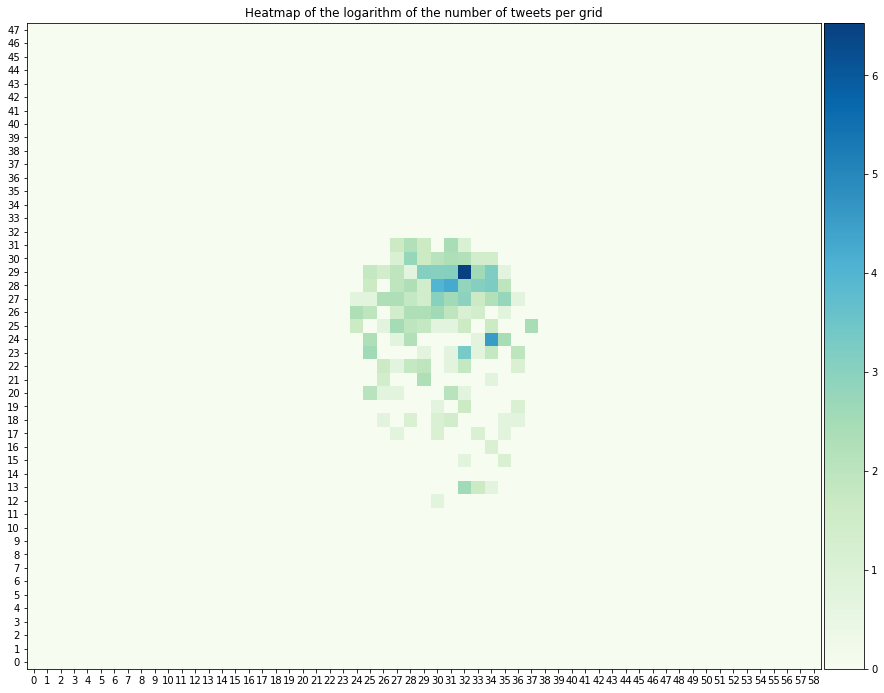

In [7]:
heatmap_fig, heatmap_ax = plt.subplots(figsize = (15, 18))
heatmap_ax.set_title('Heatmap of the logarithm of the number of tweets per grid')
heatmap_ax.set_xticks(np.arange(n_col))
heatmap_ax.set_yticks(np.arange(n_row))
grids_map_log = np.log(grids_map, out = np.zeros_like(grids_map, dtype = float), where = (grids_map != 0))  # Apply logarithm to the number of tweets per grid.
heatmap_img = heatmap_ax.imshow(grids_map_log, cmap = 'GnBu', origin = 'lower')
heatmap_fig.colorbar(heatmap_img, cax = make_axes_locatable(heatmap_ax).append_axes('right', size='5%', pad=0.05))  # Format the colour bar.
plt.show()

## Drawing a histogram

It can be observed from the heatmap that multiple grids contain no tweet at all, causing that the first bar in the histogram could be incredibly tall.

**NOTE:** The logarithm is applied to the number of grids to increase readability.

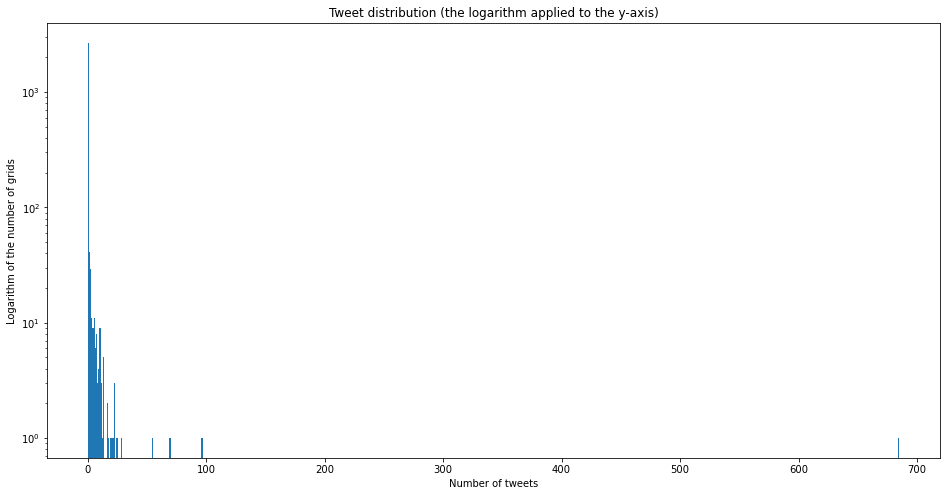

In [8]:
hist_fig, hist_ax = plt.subplots(figsize = (16, 8))
hist_ax.set_title('Tweet distribution (the logarithm applied to the y-axis)')
hist_ax.set_xlabel('Number of tweets')
hist_ax.set_ylabel('Logarithm of the number of grids')
hist_ax.hist(n_tweets_list, bins = np.max(n_tweets_list), log = True)
plt.show()